<a href="https://colab.research.google.com/github/catavasia/ML_FIAN-21/blob/main/seminar05_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
import sklearn.metrics as skmetrics
from sklearn.model_selection import KFold


**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [37]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:

    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)

    # plt.figure(figsize=(10, 8))
    # plt.hist(covariance, bins=10)
    # plt.xlabel('Covariance', fontsize=40)
    # plt.ylabel('N', size=40)     
    # plt.rc('xtick', labelsize=30)
    # plt.rc('ytick', labelsize=30)

    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

    # plt.figure(figsize=(10, 8))
    # plt.hist(covariance[-self.n:])
    # plt.xlabel('Covarience', fontsize=40)
    # plt.ylabel('N', size=40)     

  def best_index(self, X, y):
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    return np.argsort(np.abs(covariance))[-self.n:]


  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [38]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

In [44]:
# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)
X[:,np.sort(FeatureSelector(num_features_best).best_index(X, y))]

array([[-0.11121418, -0.6162633 , -0.54862726, ...,  0.45436006,
        -0.72084761,  0.25852764],
       [-0.20597967,  1.01514056, -1.69784511, ..., -0.7107022 ,
        -0.72220706, -0.66757048],
       [ 1.14531093, -2.29935827,  1.20088522, ..., -0.88963776,
         1.7186034 ,  1.20137827],
       ...,
       [-0.65061323,  0.96790089,  0.33318914, ..., -0.98119254,
         0.33994   , -0.59469617],
       [-1.61218259, -0.84579808,  0.92814522, ..., -1.03922707,
        -0.66551709,  0.36789514],
       [-0.81467255, -1.57022002,  0.98430574, ...,  0.76411053,
         0.75841569,  0.9425086 ]])

In [31]:
np.argsort(X_best)

array([[98, 57, 75, ..., 37,  0, 92],
       [23, 10, 92, ..., 55, 24, 85],
       [33, 26, 73, ..., 34, 85, 11],
       ...,
       [34, 22, 19, ...,  1, 60, 43],
       [ 0, 72, 70, ..., 33, 40, 73],
       [34, 36, 81, ..., 96, 65,  4]])

In [12]:
# Simple classification model
model = LinearSVC()
model.fit(X_best, y)
y_pred = model.predict(X_best)
print(f'score: {skmetrics.accuracy_score(y, y_pred)}')

# Estimating accuracy using cross-validation:
score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1)
print(f"score {score}")
cv_score = score.mean()
print(f"CV score is {cv_score}")

score: 1.0
score [0.9 0.9 0.8 0.8 0.8 1.  0.7 0.9 1.  0.8]
CV score is 0.8600000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

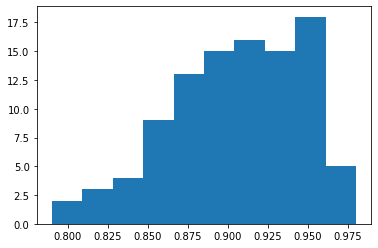

In [13]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

# Попытка объяснения

Проблема в том, что мы отбираем лучшие признаки на всей выборке. И когда мы смотрим результаты работы обученной модели на тестовой выборке, то признаки и метки тестовой выборки уже не являются независимыми величинами. Поэтому получался такой хороший результат для `accuracy`.



Теперь будем делать следующим образом:

- сначала разобъем выборку на $K$ частей. На $(K - 1)$ частях будем выделять лучшие признаки и обучать модель. На $K$-ой части будем тоже отбирать лучшие признаки и применять уже обученную модель. Тогда лучшие признаки, используемые при обучении, и метки тестовой выборки, будут независимыми величинами.

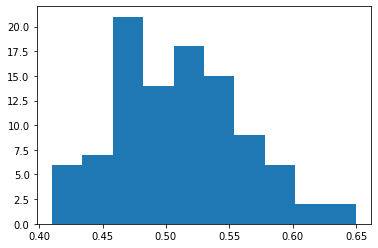

In [48]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  score = []
  kf = KFold(n_splits=5)
  for train, test in kf.split(X, y):
    #print("%s %s" % (train, test))
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    X_train_best = FeatureSelector(num_features_best).fit_transform(X_train, y_train)
    best_feature_index = FeatureSelector(num_features_best).best_index(X_train, y_train)
    X_test_best = X_test[:,np.sort(FeatureSelector(num_features_best).best_index(X_train, y_train))]

    model = LinearSVC()
    model.fit(X_train_best, y_train)
    y_pred = model.predict(X_test_best)
    accuracy_score = skmetrics.accuracy_score(y_test, y_pred)
    #print(f'score: {accuracy_score}')
    score.append(accuracy_score)
  return np.array(score).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);


Среднее значение для `accuracy` около 0.5, что и ожидалось.